In [1]:
import os, glob, re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

FEATURE_DIR = "NSR_SCD_FEATS_EX"   # change if needed

In [2]:
def parse_filename(path):
    name = os.path.basename(path)
    is_scd = name.startswith("SCD")
    parts  = name.split('_')
    subj   = parts[1]
    ordinal = parts[2]                # First…Sixth
    order = ["First","Second","Third","Fourth","Fifth","Sixth"]
    idx = order.index(ordinal)
    # SCD order reversed: Sixth→0 … First→5
    idx = 5 - idx if is_scd else idx
    return int(is_scd), subj, idx

In [3]:
FEATURE_DIR = "NSR_SCD_FEATS_EX" 

def load_subject_dict(feature_dir):
    subj_map = {}
    for path in glob.glob(os.path.join(feature_dir, "*.csv")):
        label, subj, seg_idx = parse_filename(path)
        features = pd.read_csv(path).values.squeeze()   # eight‑element row

        print(label, features)
        if subj not in subj_map:
            subj_map[subj] = {"label": label, "segments": [None]*6}
        subj_map[subj]["segments"][seg_idx] = features
    # check completeness
    # for s, info in subj_map.items():
    #     if None in info["segments"]:
    #         raise ValueError(f"Subject {s} missing segment(s)")
    return subj_map

subject_dict = load_subject_dict(FEATURE_DIR)
print("Loaded", len(subject_dict), "subjects")

0 [0.7628077  0.32957674 0.03820513 0.22607643 0.02963741 0.149
 0.5859375  2.3671875 ]
0 [0.72310915 0.37386428 0.04552058 0.27241548 0.0376728  0.188
 0.5078125  2.5       ]
0 [0.76578608 0.34806866 0.04005168 0.24525634 0.03202674 0.155
 0.6171875  2.7578125 ]
0 [0.61649485 0.33394713 0.05475207 0.24804254 0.04023432 0.265
 0.3671875  2.25      ]
0 [0.78543307 0.36229085 0.04894737 0.26408974 0.03362346 0.186
 0.5859375  2.25      ]
0 [0.78034777 0.31394761 0.05342105 0.23146456 0.02966172 0.203
 0.5        2.078125  ]
0 [0.69551235 0.51237611 0.09393939 0.3568464  0.05130698 0.403
 0.25       2.5625    ]
0 [0.69657494 0.50386794 0.0943662  0.36251678 0.05204275 0.402
 0.125      2.0390625 ]
0 [0.72401536 0.47834206 0.08731707 0.36726377 0.05072596 0.358
 0.125      2.859375  ]
0 [0.62947368 0.45919998 0.09092827 0.31560428 0.0501378  0.431
 0.1328125  1.8046875 ]
0 [0.66488211 0.50291776 0.09731544 0.32376281 0.04869477 0.435
 0.2578125  2.3125    ]
0 [0.67767654 0.58217566 0.08630

In [4]:
X_tr, y_tr, X_te, y_te = [], [], [], []

for subj, info in subject_dict.items():
    lbl  = info["label"]
    segs = info["segments"]
    X_tr.append(segs[0])              # first 5‑min
    y_tr.append(lbl)
    X_te.extend(segs[1:])             # remaining 5
    y_te.extend([lbl]*5)

In [5]:
X_tr = np.vstack(X_tr)
#X_te = np.vstack(X_te)
y_tr = np.array(y_tr)
#y_te = np.array(y_te)

In [6]:
scaler = StandardScaler().fit(X_tr)

In [7]:
X_tr = scaler.transform(X_tr)
#X_te = scaler.transform(X_te)

In [8]:
X_tr = np.pad(X_tr, ((0,0),(0,1)))
#X_te = np.pad(X_te, ((0,0),(0,1)))

In [9]:
N_FILT, K, DIL_BASE, DROP, DENSE = 64, 2, [1,2,4,8,16,32,64], 0.5, 512

# def build_wavenet(depth, lr):
#     dil = DIL_BASE[:depth]
#     inp = Input(shape=(9,))
#     x   = layers.Reshape((9,1))(inp); skips=[]
#     for d in dil:
#         t=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='tanh')(x)
#         s=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='sigmoid')(x)
#         g=layers.Multiply()([t,s])
#         skips.append(layers.TimeDistributed(layers.Dense(N_FILT,activation='relu'))(g))
#         x=layers.Add()([x,g])
#     x=layers.Add()(skips); x=layers.Activation('relu')(x); x=layers.Flatten()(x)
#     x=layers.Dropout(DROP)(x); x=layers.Dense(DENSE,activation='relu')(x); x=layers.Dropout(DROP)(x)
#     out=layers.Dense(1,activation='sigmoid')(x)
#     m=Model(inp,out); m.compile(tf.keras.optimizers.Adam(lr),'binary_crossentropy',['accuracy'])
#     return m

def build_wavenet(depth, lr):
    dilations = DIL_BASE[:depth]
    inp = Input(shape=(9,))
    x   = layers.Reshape((9,1))(inp)
    skips = []
    for d in dilations:
        t = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="tanh")(x)
        s = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="sigmoid")(x)
        g = layers.Multiply()([t, s])
        skips.append(layers.TimeDistributed(layers.Dense(N_FILT,
                               activation="relu"))(g))
        x = layers.Add()([x, g])          # residual
    x = layers.Add()(skips)
    x = layers.Activation("relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(DROP)(x)
    x = layers.Dense(DENSE, activation="relu")(x)
    x = layers.Dropout(DROP)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [9]:
# ──────────────────────────────────────────────────────────────
# Helper blocks
def Inception1D(x, filters=64, k_list=(2,3,4), dilation=1, prefix="Inc"):
    branches = []
    for k in k_list:
        b = layers.Conv1D(filters, k, padding="causal",
                          dilation_rate=dilation,
                          activation="relu",
                          name=f"{prefix}_conv{k}")(x)
        branches.append(b)
    return layers.Concatenate(name=f"{prefix}_concat")(branches)

def DenseBlock1D(x, layers_n=4, growth=32, prefix="Dense"):
    concat_feats = [x]
    for i in range(layers_n):
        z = layers.Conv1D(4*growth, 1, padding="same",
                          activation="relu",
                          name=f"{prefix}_bottleneck{i}")(layers.Concatenate()(concat_feats))
        z = layers.Conv1D(growth, 3, padding="causal",
                          activation="relu",
                          name=f"{prefix}_conv{i}")(z)
        concat_feats.append(z)
    return layers.Concatenate(name=f"{prefix}_out")(concat_feats)

def SE_ChannelAttention(x, reduction=8, prefix="SE"):
    ch = x.shape[-1]
    s = layers.GlobalAveragePooling1D()(x)
    s = layers.Dense(ch//reduction, activation="relu", name=f"{prefix}_fc1")(s)
    s = layers.Dense(ch, activation="sigmoid", name=f"{prefix}_fc2")(s)
    s = layers.Reshape((1, ch))(s)
    return layers.Multiply(name=f"{prefix}_scale")([x, s])

# ──────────────────────────────────────────────────────────────
# Build the full model
def build_hybrid_cnn(input_len=9, lr=1e-3, n_classes=2):
    inp = Input(shape=(input_len,), name="Input")
    x0 = layers.Reshape((input_len,1))(inp)

    # initial point-wise embedding
    embed = layers.Conv1D(128, 1, activation="relu", name="Embed")(x0)
    embed = layers.BatchNormalization()(embed)

    # Inception block #1
    inc1 = Inception1D(embed, filters=64, prefix="Inc1")

    # Residual-Dense block
    dense = DenseBlock1D(inc1, layers_n=4, growth=32, prefix="DenseBlk")
    # project back to same depth as inception output for residual add
    dense_proj = layers.Conv1D(inc1.shape[-1], 1, padding="same",
                               name="DenseProj")(dense)
    res1 = layers.Add(name="DenseResidual")([inc1, dense_proj])

    # SE-attention
    attn = SE_ChannelAttention(res1, prefix="SE")

    # Inception block #2 with dilation
    inc2 = Inception1D(attn, filters=64, dilation=2, prefix="Inc2")

    # Global context: concat Inc2 pool with pooled embed
    pool_main  = layers.GlobalAveragePooling1D()(inc2)
    pool_embed = layers.GlobalAveragePooling1D()(embed)
    concat = layers.Concatenate(name="GlobalConcat")([pool_main, pool_embed])

    # Classifier head
    x = layers.Dense(256, activation="relu")(concat)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1 if n_classes==1 else n_classes,
                       activation="sigmoid" if n_classes==1 else "softmax",
                       name="Output")(x)

    model = Model(inp, out, name="Hybrid_Inception_Dense_SE")
    model.compile(tf.keras.optimizers.Adam(lr),
                  loss="binary_crossentropy" if n_classes==1 else "categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# quick summary
model = build_hybrid_cnn()
model.summary(line_length=110)


Model: "Hybrid_Inception_Dense_SE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape              ┃          Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)             │ (None, 9)                 │                0 │ -                          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ reshape (Reshape)              │ (None, 9, 1)              │                0 │ Input[0][0]                │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ Embed (Conv1D)                 │ (None, 9, 128)            │              256 │ reshape[0][0]              │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ batch_normalization            │ (None, 9, 128)            │              512 │ Embed[0][0]                │
│ (BatchNormalization)           │                           │                  │                            │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ Inc1_conv2 (Conv1D)            │ (None, 9, 64)             │           16,448 │ batch_normalization[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ Inc1_conv3 (Conv1D)            │ (None, 9, 64)             │           24,640 │ batch_normalization[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ Inc1_conv4 (Conv1D)            │ (None, 9, 64)             │           32,832 │ batch_normalization[0][0]  │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ Inc1_concat (Concatenate)      │ (None, 9, 192)            │                0 │ Inc1_conv2[0][0],          │
│                                │                           │                  │ Inc1_conv3[0][0],          │
│                                │                           │                  │ Inc1_conv4[0][0]           │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ concatenate (Concatenate)      │ (None, 9, 192)            │                0 │ Inc1_concat[0][0]          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ DenseBlk_bottleneck0 (Conv1D)  │ (None, 9, 128)            │           24,704 │ concatenate[0][0]          │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ DenseBlk_conv0 (Conv1D)        │ (None, 9, 32)             │           12,320 │ DenseBlk_bottleneck0[0][0] │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)    │ (None, 9, 224)            │                0 │ Inc1_concat[0][0],         │
│                                │                           │                  │ DenseBlk_conv0[0][0]       │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ DenseBlk_bottleneck1 (Conv1D)  │ (None, 9, 128)            │           28,800 │ concatenate_1[0][0]        │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ DenseBlk_conv1 (Conv1D)        │ (None, 9, 32)             │           12,320 │ DenseBlk_bottleneck1[0][0] │
├────────────────────────────────┼───────────────────────────┼──────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)    │ (None, 9, 256)            │                0 │ Inc1_concat[0][0],         │
│   

 Total params: 544,409 (2.08 MB)

 Trainable params: 544,153 (2.08 MB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
configs = [(0.1),(0.01),(0.001),(0.0001)]
histories, models = {}, {}
for lr in configs:
    key=f"_lr{lr}"
    print("Training",key)
    m=build_hybrid_cnn(lr=lr)
    h=m.fit(X_tr,y_tr,epochs=50,batch_size=64,verbose=0)   # no validation
    histories[key]=h
    models[key]=m
    print("  final loss=",h.history['loss'][-1]," acc=",h.history['accuracy'][-1])


Training _lr0.1
  final loss= 6.544960975646973  acc= 0.8333333134651184
Training _lr0.01
  final loss= 0.13549400866031647  acc= 0.9166666865348816
Training _lr0.001
  final loss= 0.006346290465444326  acc= 1.0
Training _lr0.0001
  final loss= 0.32870593667030334  acc= 0.9166666865348816


In [12]:
best_key = min(histories,
               key=lambda k:(histories[k].history['loss'][-1],
                             -histories[k].history['accuracy'][-1]))
best_model = models[best_key]
print("BEST model →", best_key)

BEST model → _lr0.001


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1644\830598025.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


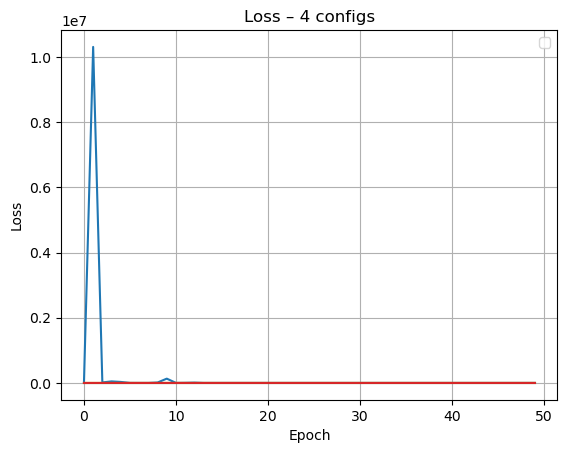

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1644\830598025.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


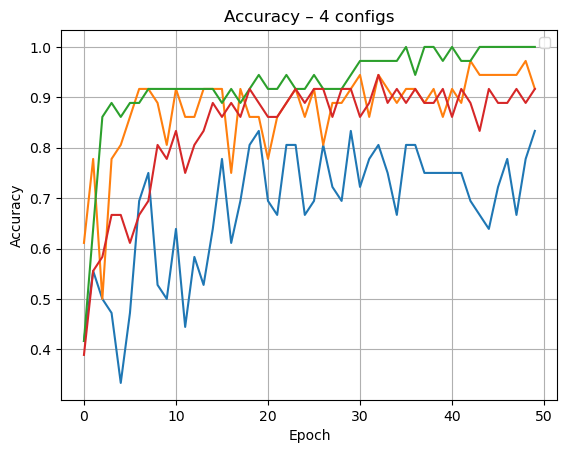

In [13]:
import matplotlib.pyplot as plt
# 1+2 plots
plt.figure(); 
plt.title("Loss – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['loss'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); 
plt.grid(); 
plt.show()

plt.figure(); 
plt.title("Accuracy – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['accuracy'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.grid(); 
plt.show()

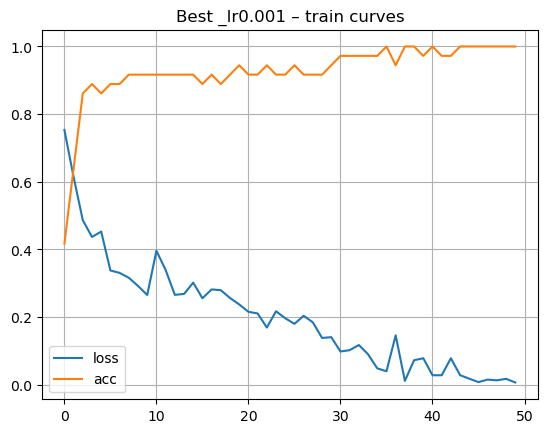

In [14]:
# 3 detailed curve for best
h=histories[best_key]
plt.figure(); 
plt.plot(h.history['loss'],label='loss'); 
plt.plot(h.history['accuracy'],label='acc')
plt.title(f"Best {best_key} – train curves"); 
plt.legend(); 
plt.grid(); 
plt.show()

In [15]:
slice_X, slice_y = [[] for _ in range(5)], [[] for _ in range(5)]

for subj, info in subject_dict.items():
    lbl  = info["label"]
    for i in range(5):
        slice_X[i].append(info["segments"][i+1])
        slice_y[i].append(lbl)

In [16]:
slice_X = [np.vstack(s) for s in slice_X]
slice_y = [np.array(s)   for s in slice_y]

In [17]:
slice_X = [np.pad(scaler.transform(s),((0,0),(0,1))) for s in slice_X]

In [18]:

# 4 confusion per slice
global_cm=np.zeros((2,2),int)
for i,(X_s,y_s) in enumerate(zip(slice_X,slice_y),start=2):
    y_pr=(best_model.predict(X_s).ravel()>=0.5).astype(int)
    cm=confusion_matrix(y_s,y_pr); global_cm+=cm
    tn,fp,fn,tp=cm.ravel()
    acc=(tp+tn)/cm.sum(); sens=tp/(tp+fn); spec=tn/(tn+fp); prec=tp/(tp+fp)
    print(f"Slice {i}‑th 5‑min  CM={cm.tolist()}  Acc={acc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  Prec={prec:.3f}")
    print(f"\\nGLOBAL CM =\\n", global_cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Slice 2‑th 5‑min  CM=[[17, 1], [8, 10]]  Acc=0.750  Sens=0.556  Spec=0.944  Prec=0.909
[[17  1] CM =\n 
 [ 8 10]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
Slice 3‑th 5‑min  CM=[[17, 1], [9, 9]]  Acc=0.722  Sens=0.500  Spec=0.944  Prec=0.900
\nGLOBAL CM =\n [[34  2]
 [17 19]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Slice 4‑th 5‑min  CM=[[18, 0], [9, 9]]  Acc=0.750  Sens=0.500  Spec=1.000  Prec=1.000
\nGLOBAL CM =\n [[52  2]
 [26 28]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Slice 5‑th 5‑min  CM=[[18, 0], [10, 8]]  Acc=0.722  Sens=0.444  Spec=1.000  Prec=1.000
\nGLOBAL CM =\n [[70  2]
 [36 36]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Slice 6‑th 5‑min  CM=[[18, 0], [9, 9]]  Acc=0.750  Sens=0.500  Spec=1.000  Prec=1.000
\nGLOBAL CM =\n [[88  2]
 [45 45]]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1644\2904249774.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()


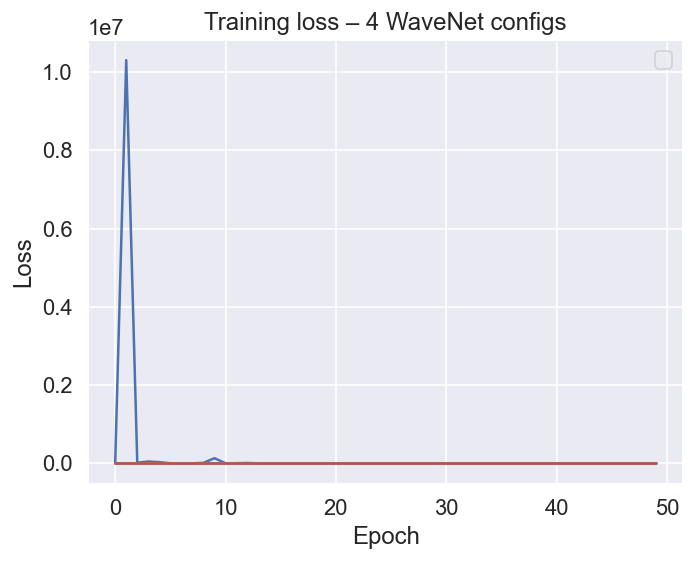

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1644\2904249774.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()


MemoryError: bad allocation

<Figure size 768x576 with 1 Axes>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, rc={"figure.dpi":120})

# ──────────────────────────────────────────
# ① Loss curves of the four configs
plt.figure()
for k,h in histories.items():
    plt.plot(h.history['loss'], label=k)
plt.title("Training loss – 4 WaveNet configs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
plt.show()

# ② Accuracy curves of the four configs
plt.figure()
for k,h in histories.items():
    plt.plot(h.history['accuracy'], label=k)
plt.title("Training accuracy – 4 WaveNet configs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()
plt.show()

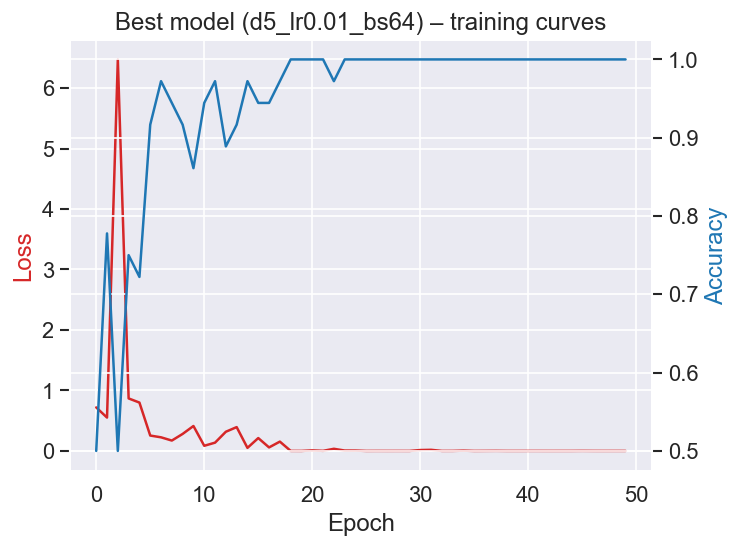

In [19]:
# ③ Detailed loss + acc for the best model
best_hist = histories[best_key]
fig, ax1 = plt.subplots()
ax1.plot(best_hist.history['loss'], label="loss", color="tab:red")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss", color="tab:red")
ax2 = ax1.twinx()
ax2.plot(best_hist.history['accuracy'], label="acc", color="tab:blue")
ax2.set_ylabel("Accuracy", color="tab:blue")
plt.title(f"Best model ({best_key}) – training curves")
fig.tight_layout(); plt.grid(True); plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


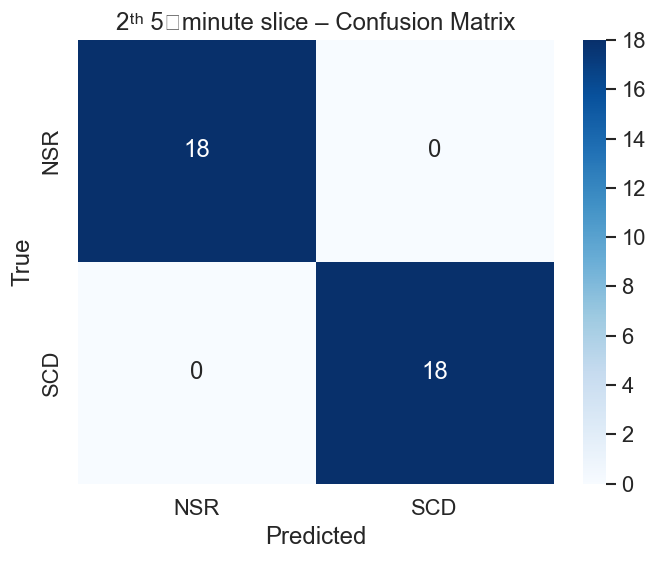

Slice 2:  Acc=1.000  Sens=1.000  Spec=1.000  Prec=1.000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


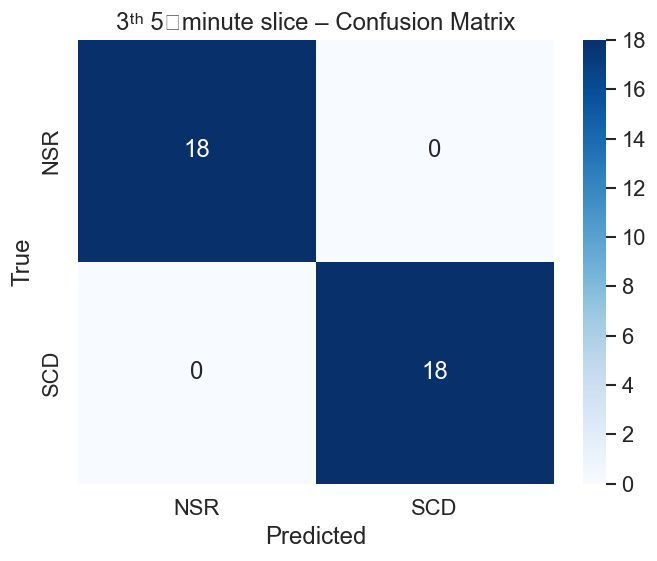

Slice 3:  Acc=1.000  Sens=1.000  Spec=1.000  Prec=1.000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


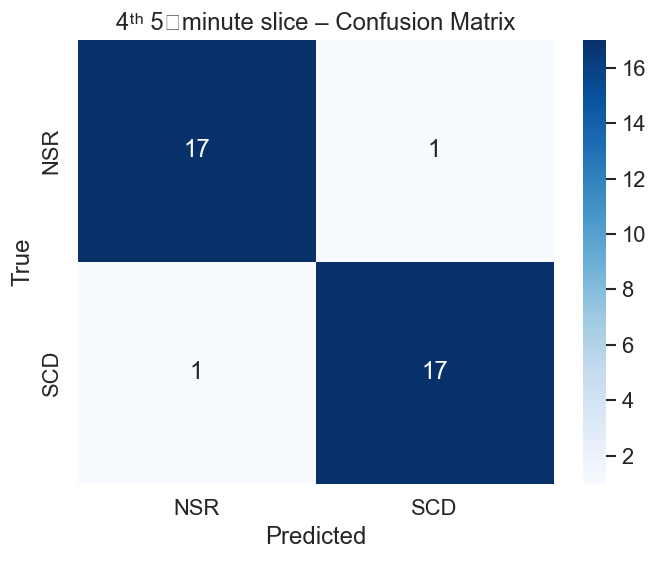

Slice 4:  Acc=0.944  Sens=0.944  Spec=0.944  Prec=0.944
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


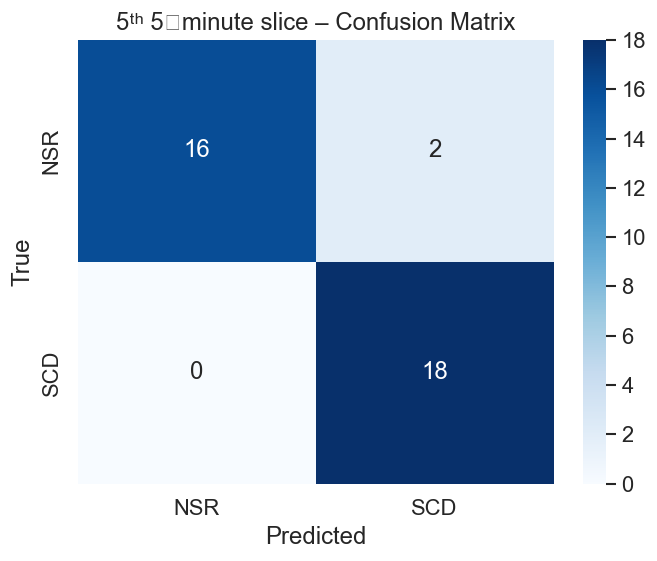

Slice 5:  Acc=0.944  Sens=1.000  Spec=0.889  Prec=0.900
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Lenovo\anaconda3\envs\notebook\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


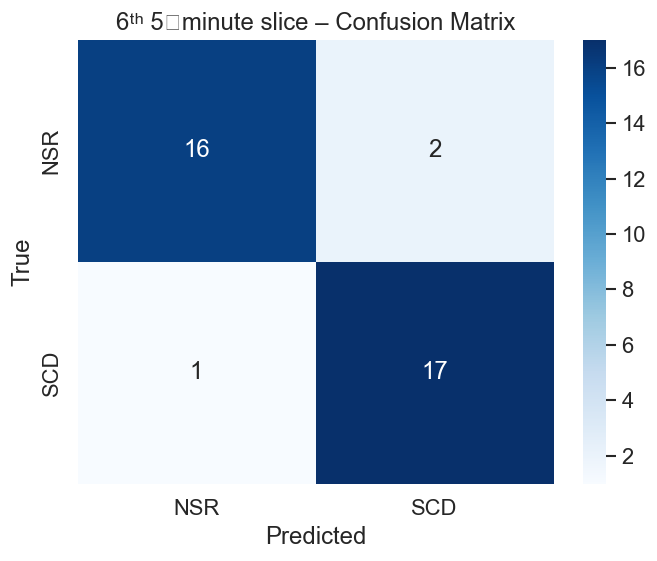

Slice 6:  Acc=0.917  Sens=0.944  Spec=0.889  Prec=0.895


In [20]:
# ──────────────────────────────────────────
# ④ Slice‑wise confusion matrices (heat‑maps)
labels = ["NSR", "SCD"]
global_cm = np.zeros((2,2), int)

for idx, (X_s, y_s) in enumerate(zip(slice_X, slice_y), start=2):
    y_pred = (best_model.predict(X_s).ravel() >= 0.5).astype(int)
    cm = confusion_matrix(y_s, y_pred)
    global_cm += cm

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{idx}ᵗʰ 5‑minute slice – Confusion Matrix")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    acc  = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp+fn) else 0
    spec = tn / (tn + fp) if (tn+fp) else 0
    prec = tp / (tp + fp) if (tp+fp) else 0
    print(f"Slice {idx}:  Acc={acc:.3f}  Sens={sens:.3f}  "
          f"Spec={spec:.3f}  Prec={prec:.3f}")

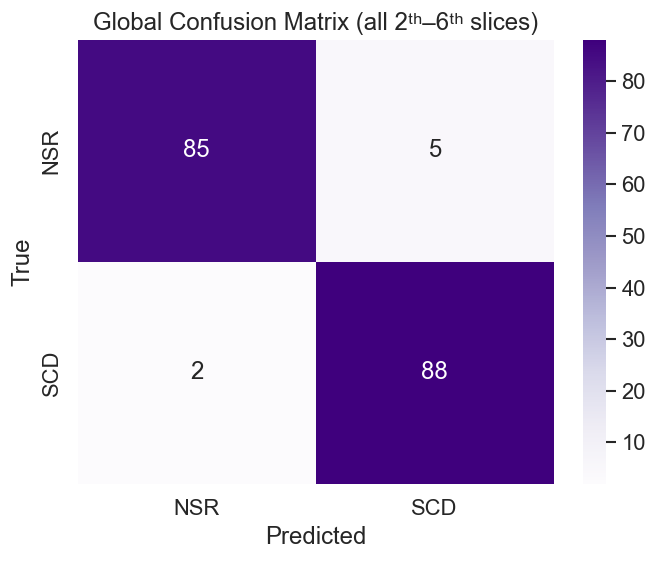


Global metrics →  Acc=0.961  Sens=0.978  Spec=0.944  Prec=0.946  F1=0.962


In [21]:
# Global confusion matrix (all test segments combined)
plt.figure()
sns.heatmap(global_cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Global Confusion Matrix (all 2ᵗʰ–6ᵗʰ slices)")
plt.show()

tn, fp, fn, tp = global_cm.ravel()
acc  = (tp + tn) / global_cm.sum()
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f1   = 2*prec*sens/(prec+sens)
print(f"\nGlobal metrics →  Acc={acc:.3f}  Sens={sens:.3f}  "
      f"Spec={spec:.3f}  Prec={prec:.3f}  F1={f1:.3f}")